# XGBoost Models | varying depths of the ocean

**XGBRegressor**

Josie Donnelly

*Last updated 10.09.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import Normalize, LogNorm

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load satellite data
sat_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
sat_data_file = 'satData.csv'
sat_df = pd.read_csv(sat_data_path + sat_data_file)

# add date column as datetime
sat_df.rename({'date': 'date_str'}, axis=1, inplace=True)
sat_df.insert(loc=list(sat_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in sat_df['date_str']])

# add the day of the year in radians
sat_df.insert(loc=list(sat_df.columns).index('date'), column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in sat_df['date']])

# drop long term average columns
for c in sat_df.columns:
    if c.startswith('LT'):
        sat_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
sat_df = sat_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {sat_df.shape}\n')

print(f'missing values:\n---------------\n{sat_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(sat_df["float"]))}\n')

sat_df


shape: (52038, 11)

missing values:
---------------
float              0
cycleNumber        0
day_of_year_rad    0
date               0
date_str           0
latitude           0
longitude          0
elevation          0
MO_SAT_SST         0
MO_SAT_CHL         0
MO_SAT_BBP         0
dtype: int64

number of unique floats: 553



,float,cycleNumber,day_of_year_rad,date,date_str,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,2.167505,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,2,2.167505,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081
2,1902303,3,2.184708,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185
3,1902303,4,2.201910,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767
4,1902303,5,2.219113,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677
...,...,...,...,...,...,...,...,...,...,...,...
52033,7901001,11,1.410599,2022-03-23 11:26:00,2022-03-23 11:26:00,17.130858,-24.169882,-3323.5,21.762587,0.390988,0.001562
52034,7901001,12,1.445004,2022-03-25 11:31:00,2022-03-25 11:31:00,16.967572,-23.922267,-3457.5,21.850749,0.208484,0.001078
52035,7901001,13,1.479408,2022-03-27 11:57:00,2022-03-27 11:57:00,16.803187,-23.777600,-3359.5,21.975307,0.162081,0.001127
52036,7901001,14,1.513813,2022-03-29 11:35:00,2022-03-29 11:35:00,16.647572,-23.731805,-3358.5,22.266691,0.179276,0.001053


In [3]:
# load float data with location
float_loc_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
float_loc_data_file = 'floatLocData.csv'

try:
    # read saved joined dataframe
    date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    float_loc_df = pd.read_csv(float_loc_data_path + float_loc_data_file, parse_dates=['date'], date_parser=date_parser)     #.drop(columns='date')
#     float_loc_df.insert(loc=list(float_loc_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_loc_df['date_str']])
    
except FileNotFoundError:   
    print('Joining profile data on global float data...')
    start_time = time()
    
    # load float profile data
    float_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
    float_data_file = 'profileData.csv'
    float_df = pd.read_csv(float_data_path + float_data_file)

    # add date column as datetime
    float_df.rename({'date': 'date_str'}, axis=1, inplace=True)
    float_df.insert(loc=list(float_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_df['date_str']])

    # join float profile data on location
    float_loc_df = pd.DataFrame(columns=list(float_df.columns)[:1] + ['latitude', 'longitude'] + list(float_df.columns)[1:])
    for f in np.unique(float_df['float']):
        tmp_float_df = float_df[float_df['float'] == f]
        tmp_loc_df = loc_df[loc_df['float'] == f]
        tmp_df = tmp_loc_df.join(other=tmp_float_df.set_index('date'), on='date', how='inner', rsuffix='_copy')
        for c in tmp_df.columns:
            if c.endswith('_copy'):
                tmp_df.drop(columns=c, inplace=True)
        try:
            float_loc_df = pd.concat([float_loc_df, tmp_df])
        except:
            print(f'error with feature {f}')

    float_loc_df = float_loc_df.reset_index(drop=True)
    
    # confirm that the satellite and float data files contain information for exactly the same floats
    print(f"satellite and float data file contain information for exactly the same floats: {np.array_equal(np.unique(float_df['float']), np.unique(sat_df['float']))}")

    # save joined table locally
    print(f'Saving joined table to {float_loc_data_path + float_loc_data_file}...')
    float_loc_df.to_csv(float_loc_data_path + float_loc_data_file, index=False, date_format='%Y-%m-%d %H:%M:%S')
    print(f'Done -- time taken = {time() - start_time:.4f}s')

# either way, display dataframe information and data

# drop irrelevant columns
for c in float_loc_df.columns:
    if c not in ['float', 'latitude', 'longitude', 'date', 'date_str', 'PRES', 'BBP700', 'CHLA']:
        float_loc_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
float_loc_df = float_loc_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {float_loc_df.shape}\n')

print(f'missing values:\n---------------\n{float_loc_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(float_loc_df["float"]))}\n')

float_loc_df


shape: (33057018, 8)

missing values:
---------------
float        0
latitude     0
longitude    0
date         0
date_str     0
PRES         0
BBP700       0
CHLA         0
dtype: int64

number of unique floats: 565



,float,latitude,longitude,date,date_str,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,3,0.001788,6.958747e-01
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,4,0.001788,6.958747e-01
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,6,0.001788,6.964993e-01
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,8,0.001789,7.164887e-01
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,10,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...
33057013,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,968,0.000216,-3.686869e-05
33057014,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,975,0.000216,-1.843434e-05
33057015,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,977,0.000216,2.543358e-18
33057016,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,982,0.000216,2.543358e-18


## Define functions

In [4]:
# # function to join CHLA data onto satellite information based on lat, long, and date
# def get_data_by_depth(feat_df, target_df, depth_bin, verbose=0):
    
#     depth_df = target_df[target_df['depth_bin'] == depth_bin]
#     chla_vals = []
#     rows_to_drop = []
#     for i in range(feat_df.shape[0]) and verbose > 0:
#         if i%1000 == 0:
#             print(f'row {i}')
#         row = feat_df.loc[i]
#         tmp_df = depth_df[(depth_df['date'] == row['date']) & (depth_df['float'] == row['float'])]
#         if tmp_df.shape[0] > 0:
#             chla_vals.append(np.mean(tmp_df['CHLA']))
#         else:
#             rows_to_drop.append(i)

#     data_df = feat_df.drop(labels=rows_to_drop, axis='index').reset_index(drop=True)
#     data_df['target_CHLA'] = chla_vals
    
#     # data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation', 'MO_SAT_CHL'], inplace=True)
#     data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation'], inplace=True)

#     return data_df


In [5]:
# function to cross validate and display scores
def get_model_scores(model, X, y, metrics=['neg_mean_squared_error', 'r2'], n_cv_folds=5):
    scores = cross_validate(model, X, y, cv=n_cv_folds,
                           scoring=metrics,
                           return_estimator=True,
                           return_train_score=True)
    
    vals = []
    for group in ['train', 'test']:
        for metric in metrics:
            if metric == 'neg_mean_squared_error':
                val = np.mean(-scores[f'{group}_{metric}'])
                metric = 'MSE'
            else:
                val = np.mean(scores[f'{group}_{metric}'])
            
            if group == 'test':
                print(f"{f'Average validation {metric}:':<25} {val:.4f}")
            else:
                print(f"{f'Average {group} {metric}:':<25} {val:.4f}")
                
            vals.append(val)
            
        print()
        
    
    return vals


In [6]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    print(f"{'Final test MSE:':<25} {mean_squared_error(y_test, test_preds):.4f}")
    print(f"{'Final test r2:':<25} {r2_score(y_test, test_preds):.4f}")
    
    return train_preds, test_preds
    

In [7]:
# # display the results of the regression as scatter plots: predicted value vs. target
# def plot(y_train, train_preds, y_test, test_preds, subtitle=None):  
#     plt.figure(figsize=(10,6))
#     plt.scatter(y_train, train_preds, label='train', alpha=0.7)
#     plt.scatter(y_test, test_preds, label='test', alpha=0.7)
#     if subtitle is not None:
#         subtitle = '\n' + subtitle
#     else:
#         subtitle = ''
#     plt.title(f'Predicted vs. True CHLA Values{subtitle}', fontsize='x-large')
#     plt.xlabel('true CHLA')
#     plt.ylabel('predicted CHLA')
#     plt.legend()
#     plt.show()


In [8]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(feat_df, target_df, depth_bin, verbose=0):
    
    target_df = target_df[target_df['depth_bin'] == depth_bin]
    target_df = target_df.groupby(['date', 'float'])['CHLA'].mean().to_frame().reset_index()
    data_df = feat_df.join(other=target_df.set_index('date'), on='date', how='inner', rsuffix='_copy').rename({'CHLA': 'target_CHLA'}, axis=1)
    
    # data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation', 'MO_SAT_CHL'], inplace=True)
    data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation', 'float_copy'], inplace=True)

    return data_df


In [9]:
def run_for_depth(depth_idx, intervals, data_df, results_df, plt_n_cols=5, verbose=0):
    
    start_time = time()
    
    print(f'---DEPTH {depth_idx}---')
    print(f'Interval: {intervals[depth_idx]}m to {intervals[depth_idx+1]}m')
    
    if verbose > 0:
        print('\nGet data_df')
    data_df = get_data_by_depth(sat_df, float_loc_df, depth_bin=depth_idx, verbose=0)
    
    X = data_df.drop(columns='target_CHLA')
    y = data_df['target_CHLA']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if verbose > 0:
        print(f'Num train samples: {X_train.shape[0]}')
        print(f'Num test samples: {X_test.shape[0]}')
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
          
    if verbose > 0:
        print(f'\nInput features: {list(data_df.columns)[:-1]}')
        print(f'Output: {list(data_df.columns)[-1]}')
    
    if verbose > 0:
        print('\nXGB regressor:')
    xgbr = XGBRegressor()
    scores = get_model_scores(xgbr, X_train, y_train)
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
#     plot(y_train, train_preds, y_test, test_preds, subtitle=f'test r2 = {r2_score(y_test, test_preds):.4f}')
    
    plt.subplot((len(intervals)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label='train', alpha=0.7)
    plt.scatter(y_test, test_preds, label='test', alpha=0.7)
    plt.title(f'{intervals[depth_idx]}m to {intervals[depth_idx+1]}m\ntest r2 = {r2_score(y_test, test_preds):.4f}', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend()
    
    results_df.loc[results_df.shape[0]] = [depth_idx, (intervals[depth_idx], intervals[depth_idx+1]), data_df.shape[0]] + scores
    
    print(f'\ndone--{time() - start_time:.4f}s\n')
    
    return results_df


## XGB regressor at varying depths

In [16]:
# bin the observations into depth intervals
try:
    float_loc_df.drop(columns='depth_bin', inplace=True)
except:
    pass

max_depth = max(float_loc_df['PRES'])
interval = 20
bins = np.arange(0, max_depth + interval, interval)
# bins[-1] = max_depth

depth_bins = pd.cut(float_loc_df['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

float_loc_df.insert(loc=list(float_loc_df.columns).index('PRES'), column='depth_bin', value=depth_bins)
float_loc_df


,float,latitude,longitude,date,date_str,depth_bin,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,3,0.001788,6.958747e-01
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,4,0.001788,6.958747e-01
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,6,0.001788,6.964993e-01
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,8,0.001789,7.164887e-01
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,10,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...,...
33057013,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,968,0.000216,-3.686869e-05
33057014,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,975,0.000216,-1.843434e-05
33057015,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,977,0.000216,2.543358e-18
33057016,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,49,982,0.000216,2.543358e-18


In [17]:
# initialize dataframe to store results
results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])


---DEPTH 0---
Interval: 0m to 20m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0672
Average train r2:         0.8726

Average validation MSE:   0.2072
Average validation r2:    0.6061

Final test MSE:           0.1709
Final test r2:            0.6615

done--7.2633s

---DEPTH 1---
Interval: 20m to 40m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0597
Average train r2:         0.8749

Average validation MSE:   0.1745
Average validation r2:    0.6341

Final test MSE:           0.1804
Final test r2:            0.6162

done--7.9159s

---DEPTH 2---
Interval: 40m to 60m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0406
Average train r2:         0.8395

Average validation MSE:   0.1052
Average validation r2:    0.5841

Final test MSE:           0.1068
Final test r2:            0.6004

done--8.1101s

---DEPTH 3---
Interval: 60m to 80m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0230
Average train r2:         0.8181

Average validation MSE:   0.0576
Average validation r2:    0.5428

Final test MSE:           0.0537
Final test r2:            0.5660

done--8.0890s

---DEPTH 4---
Interval: 80m to 100m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0125
Average train r2:         0.7872

Average validation MSE:   0.0297
Average validation r2:    0.4942

Final test MSE:           0.0262
Final test r2:            0.4997

done--8.0450s

---DEPTH 5---
Interval: 100m to 120m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0064
Average train r2:         0.7433

Average validation MSE:   0.0145
Average validation r2:    0.4157

Final test MSE:           0.0131
Final test r2:            0.4853

done--8.0215s

---DEPTH 6---
Interval: 120m to 140m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0035
Average train r2:         0.7284

Average validation MSE:   0.0076
Average validation r2:    0.4011

Final test MSE:           0.0076
Final test r2:            0.4178

done--8.0316s

---DEPTH 7---
Interval: 140m to 160m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0020
Average train r2:         0.7414

Average validation MSE:   0.0043
Average validation r2:    0.4582

Final test MSE:           0.0047
Final test r2:            0.4398

done--8.2001s

---DEPTH 8---
Interval: 160m to 180m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0012
Average train r2:         0.7541

Average validation MSE:   0.0027
Average validation r2:    0.4264

Final test MSE:           0.0028
Final test r2:            0.4410

done--8.1762s

---DEPTH 9---
Interval: 180m to 200m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0007
Average train r2:         0.7249

Average validation MSE:   0.0016
Average validation r2:    0.3804

Final test MSE:           0.0019
Final test r2:            0.3695

done--8.2554s

---DEPTH 10---
Interval: 200m to 220m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0004
Average train r2:         0.7330

Average validation MSE:   0.0010
Average validation r2:    0.3907

Final test MSE:           0.0010
Final test r2:            0.3972

done--8.3278s

---DEPTH 11---
Interval: 220m to 240m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0003
Average train r2:         0.7448

Average validation MSE:   0.0008
Average validation r2:    0.3378

Final test MSE:           0.0007
Final test r2:            0.3927

done--8.2820s

---DEPTH 12---
Interval: 240m to 260m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0002
Average train r2:         0.7394

Average validation MSE:   0.0006
Average validation r2:    0.2928

Final test MSE:           0.0005
Final test r2:            0.4323

done--8.2684s

---DEPTH 13---
Interval: 260m to 280m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0002
Average train r2:         0.7711

Average validation MSE:   0.0006
Average validation r2:    0.2976

Final test MSE:           0.0004
Final test r2:            0.4142

done--8.1389s

---DEPTH 14---
Interval: 280m to 300m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0002
Average train r2:         0.7709

Average validation MSE:   0.0005
Average validation r2:    0.2679

Final test MSE:           0.0007
Final test r2:            0.2523

done--8.1742s

---DEPTH 15---
Interval: 300m to 320m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.7955

Average validation MSE:   0.0005
Average validation r2:    0.2208

Final test MSE:           0.0004
Final test r2:            0.2858

done--8.0811s

---DEPTH 16---
Interval: 320m to 340m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8195

Average validation MSE:   0.0006
Average validation r2:    0.1624

Final test MSE:           0.0003
Final test r2:            0.3293

done--8.1309s

---DEPTH 17---
Interval: 340m to 360m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.7971

Average validation MSE:   0.0003
Average validation r2:    0.3108

Final test MSE:           0.0003
Final test r2:            0.3049

done--8.0861s

---DEPTH 18---
Interval: 360m to 380m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8027

Average validation MSE:   0.0003
Average validation r2:    0.2653

Final test MSE:           0.0003
Final test r2:            0.2586

done--8.0753s

---DEPTH 19---
Interval: 380m to 400m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8108

Average validation MSE:   0.0003
Average validation r2:    0.3397

Final test MSE:           0.0002
Final test r2:            0.3381

done--8.0268s

---DEPTH 20---
Interval: 400m to 420m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8302

Average validation MSE:   0.0003
Average validation r2:    0.3013

Final test MSE:           0.0003
Final test r2:            0.2359

done--7.9597s

---DEPTH 21---
Interval: 420m to 440m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8611

Average validation MSE:   0.0003
Average validation r2:    0.2590

Final test MSE:           0.0003
Final test r2:            0.1250

done--8.0675s

---DEPTH 22---
Interval: 440m to 460m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8102

Average validation MSE:   0.0003
Average validation r2:    0.2297

Final test MSE:           0.0002
Final test r2:            0.2190

done--7.8653s

---DEPTH 23---
Interval: 460m to 480m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8084

Average validation MSE:   0.0003
Average validation r2:    0.1907

Final test MSE:           0.0002
Final test r2:            -0.1103

done--8.2321s

---DEPTH 24---
Interval: 480m to 500m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8016

Average validation MSE:   0.0004
Average validation r2:    0.2029

Final test MSE:           0.0002
Final test r2:            -0.1635

done--8.0600s

---DEPTH 25---
Interval: 500m to 520m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0001
Average train r2:         0.8438

Average validation MSE:   0.0003
Average validation r2:    0.3031

Final test MSE:           0.0002
Final test r2:            0.3126

done--7.9723s

---DEPTH 26---
Interval: 520m to 540m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8604

Average validation MSE:   0.0002
Average validation r2:    0.3966

Final test MSE:           0.0001
Final test r2:            0.4669

done--7.9999s

---DEPTH 27---
Interval: 540m to 560m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8640

Average validation MSE:   0.0002
Average validation r2:    0.4118

Final test MSE:           0.0001
Final test r2:            0.5245

done--7.9717s

---DEPTH 28---
Interval: 560m to 580m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8682

Average validation MSE:   0.0002
Average validation r2:    0.4379

Final test MSE:           0.0001
Final test r2:            0.3971

done--7.9229s

---DEPTH 29---
Interval: 580m to 600m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8761

Average validation MSE:   0.0003
Average validation r2:    0.3518

Final test MSE:           0.0002
Final test r2:            0.3363

done--8.0934s

---DEPTH 30---
Interval: 600m to 620m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8751

Average validation MSE:   0.0003
Average validation r2:    0.3523

Final test MSE:           0.0002
Final test r2:            0.2600

done--8.4058s

---DEPTH 31---
Interval: 620m to 640m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8670

Average validation MSE:   0.0003
Average validation r2:    0.3222

Final test MSE:           0.0002
Final test r2:            0.3160

done--8.1604s

---DEPTH 32---
Interval: 640m to 660m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8629

Average validation MSE:   0.0003
Average validation r2:    0.3619

Final test MSE:           0.0002
Final test r2:            0.2852

done--8.2175s

---DEPTH 33---
Interval: 660m to 680m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9054

Average validation MSE:   0.0004
Average validation r2:    0.2079

Final test MSE:           0.0001
Final test r2:            0.3383

done--8.2434s

---DEPTH 34---
Interval: 680m to 700m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9460

Average validation MSE:   0.0012
Average validation r2:    0.2450

Final test MSE:           0.0003
Final test r2:            -0.3095

done--8.2245s

---DEPTH 35---
Interval: 700m to 720m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9576

Average validation MSE:   0.0045
Average validation r2:    0.2456

Final test MSE:           0.0009
Final test r2:            -0.8700

done--8.1298s

---DEPTH 36---
Interval: 720m to 740m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9554

Average validation MSE:   0.0039
Average validation r2:    -0.5673

Final test MSE:           0.0004
Final test r2:            0.2234

done--8.3572s

---DEPTH 37---
Interval: 740m to 760m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8239

Average validation MSE:   0.0001
Average validation r2:    0.5013

Final test MSE:           0.0116
Final test r2:            0.0147

done--8.5529s

---DEPTH 38---
Interval: 760m to 780m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9553

Average validation MSE:   0.0025
Average validation r2:    0.0987

Final test MSE:           0.0004
Final test r2:            0.0506

done--8.3549s

---DEPTH 39---
Interval: 780m to 800m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9286

Average validation MSE:   0.0006
Average validation r2:    0.2132

Final test MSE:           0.0003
Final test r2:            0.1177

done--8.1258s

---DEPTH 40---
Interval: 800m to 820m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8457

Average validation MSE:   0.0001
Average validation r2:    0.5752

Final test MSE:           0.0002
Final test r2:            0.4086

done--8.1083s

---DEPTH 41---
Interval: 820m to 840m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8506

Average validation MSE:   0.0001
Average validation r2:    0.5729

Final test MSE:           0.0001
Final test r2:            0.4653

done--8.0732s

---DEPTH 42---
Interval: 840m to 860m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8604

Average validation MSE:   0.0001
Average validation r2:    0.4967

Final test MSE:           0.0001
Final test r2:            0.5174

done--8.1007s

---DEPTH 43---
Interval: 860m to 880m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8714

Average validation MSE:   0.0001
Average validation r2:    0.4453

Final test MSE:           0.0001
Final test r2:            0.6639

done--8.2157s

---DEPTH 44---
Interval: 880m to 900m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8894

Average validation MSE:   0.0002
Average validation r2:    0.2917

Final test MSE:           0.0001
Final test r2:            0.6610

done--8.3826s

---DEPTH 45---
Interval: 900m to 920m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8861

Average validation MSE:   0.0002
Average validation r2:    0.3296

Final test MSE:           0.0002
Final test r2:            -0.0108

done--8.0307s

---DEPTH 46---
Interval: 920m to 940m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8793

Average validation MSE:   0.0002
Average validation r2:    0.4525

Final test MSE:           0.0001
Final test r2:            0.3149

done--8.0102s

---DEPTH 47---
Interval: 940m to 960m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8725

Average validation MSE:   0.0002
Average validation r2:    0.3784

Final test MSE:           0.0002
Final test r2:            0.1209

done--7.9156s

---DEPTH 48---
Interval: 960m to 980m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8817

Average validation MSE:   0.0002
Average validation r2:    0.4474

Final test MSE:           0.0002
Final test r2:            0.1462

done--7.9444s

---DEPTH 49---
Interval: 980m to 1000m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.8688

Average validation MSE:   0.0002
Average validation r2:    0.4274

Final test MSE:           0.0001
Final test r2:            0.6136

done--7.5279s

---DEPTH 50---
Interval: 1000m to 1020m


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


Average train MSE:        0.0000
Average train r2:         0.9936

Average validation MSE:   0.0001
Average validation r2:    0.4268

Final test MSE:           0.0000
Final test r2:            0.7170

done--0.3595s



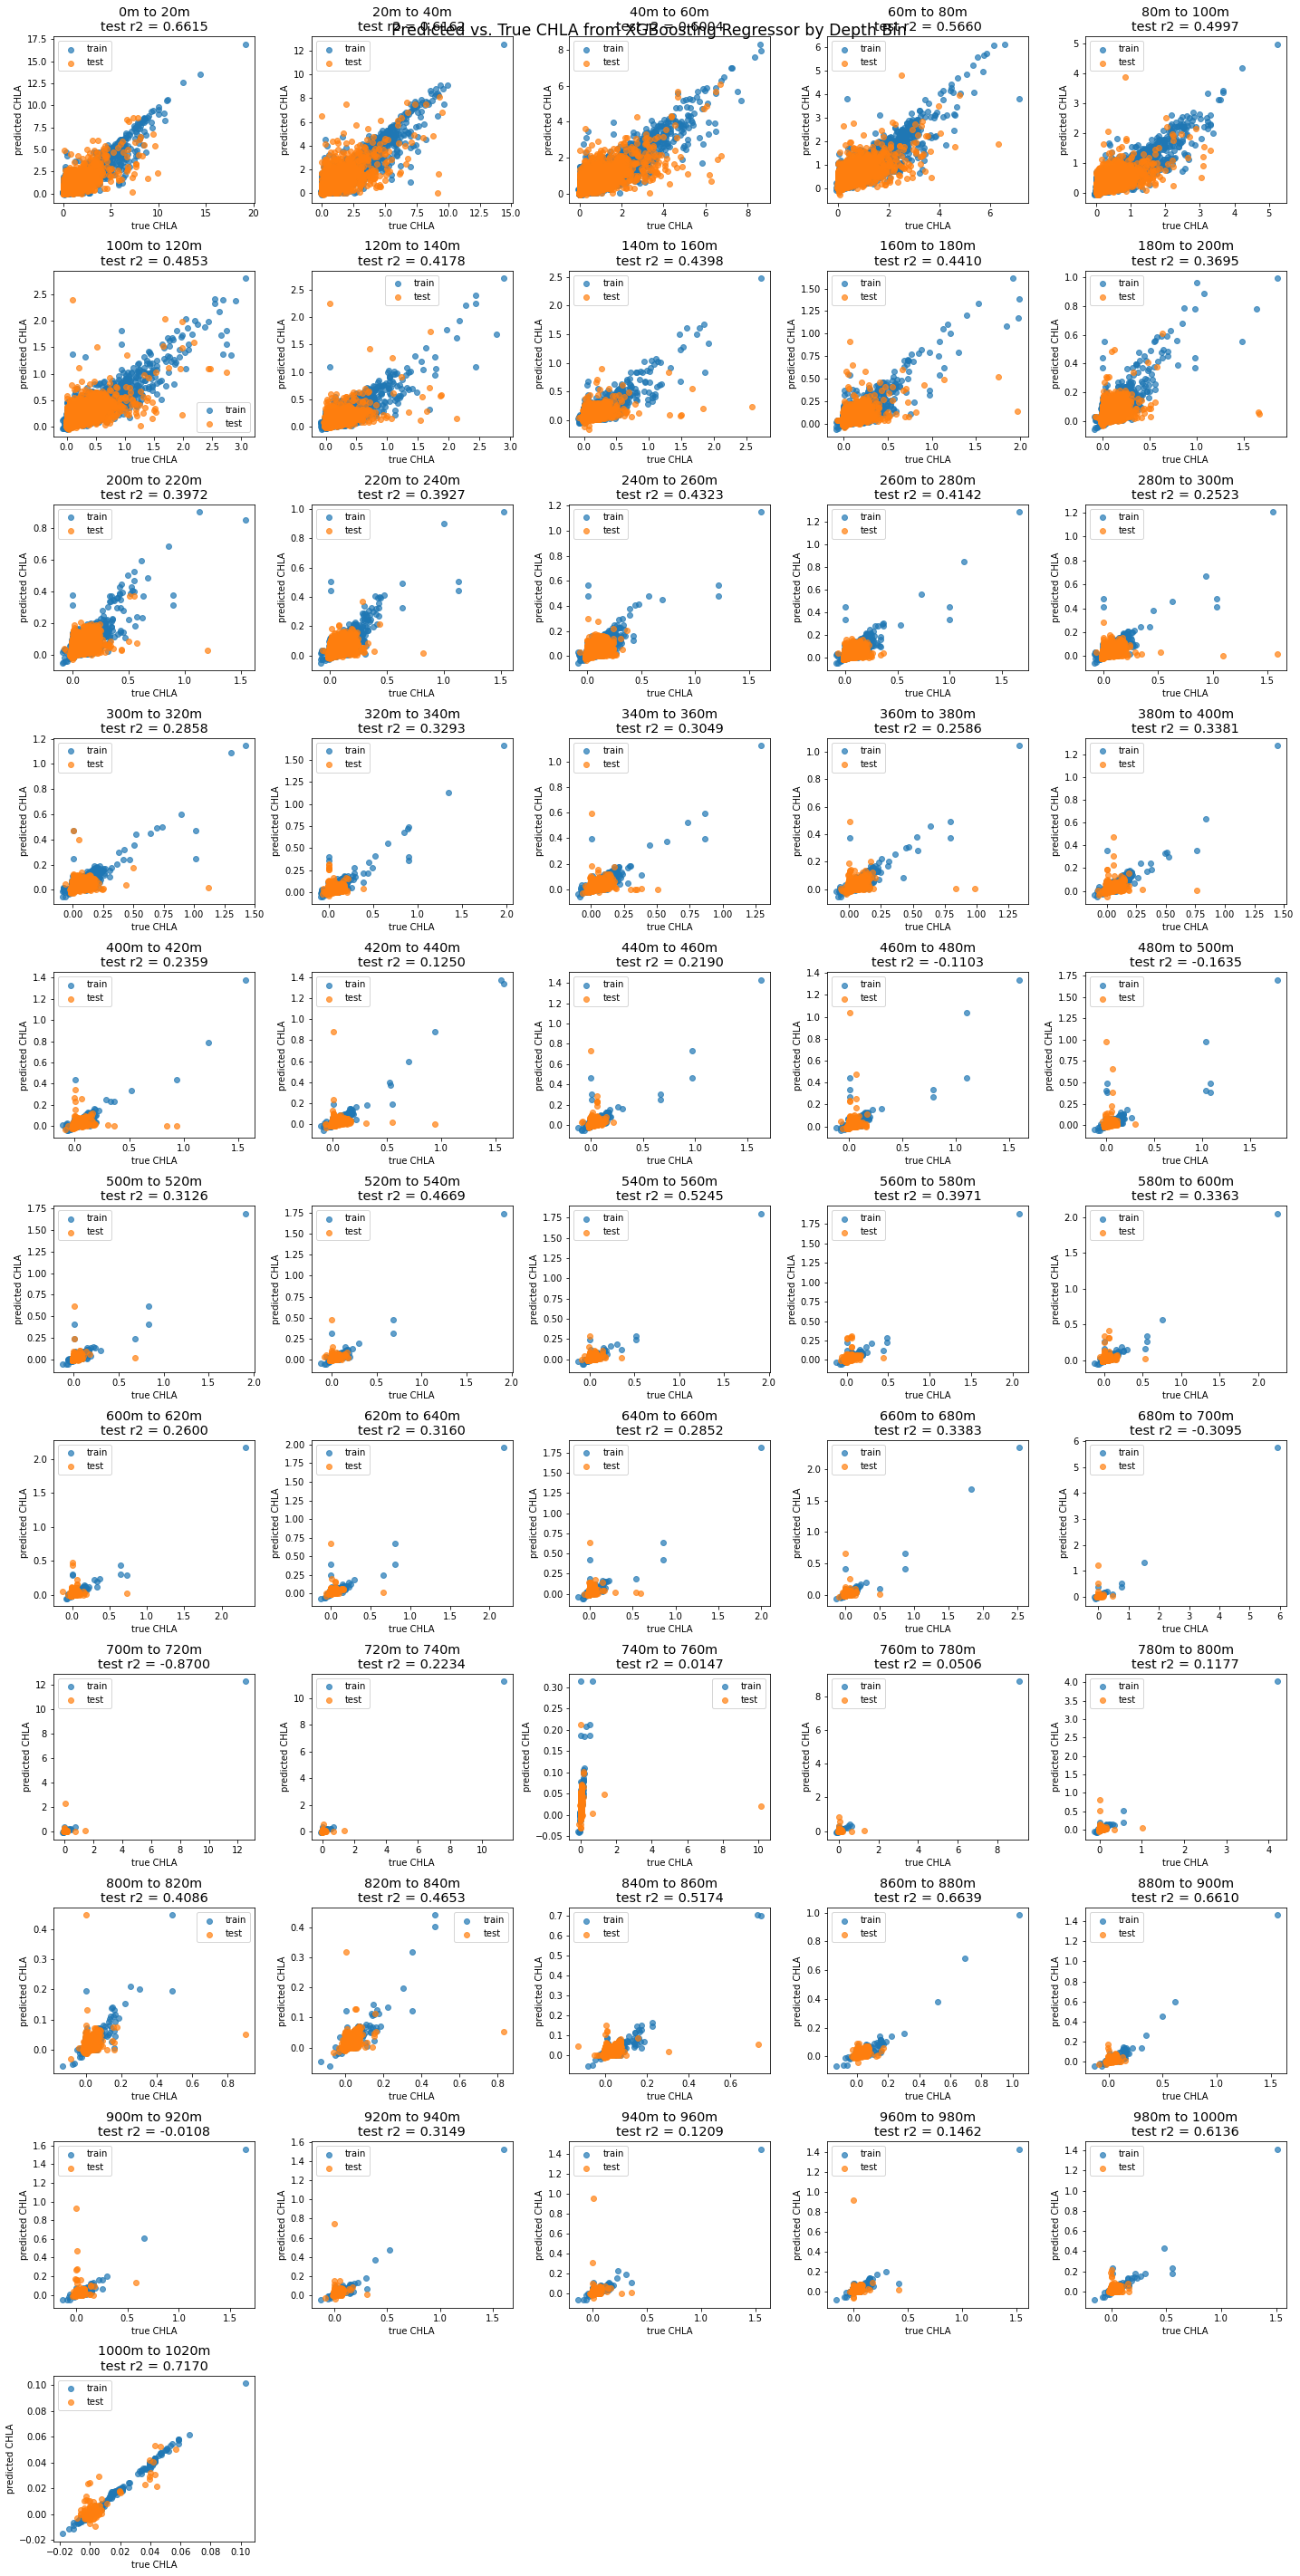

In [18]:
# fit a gradient booting regression model for the first depth bin
plt.figure(figsize=(20,40))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    data_df = get_data_by_depth(sat_df, float_loc_df, depth_bin=depth_idx, verbose=0)
    results_df = run_for_depth(depth_idx=depth_idx, intervals=bins, data_df=data_df, results_df=results_df)
    
plt.tight_layout()
plt.show()


## Display XGBoost regressor results

In [19]:
# display the dataframe od results
results_df


,depth_idx,depth_interval,num_observations,train_mse,train_r2,test_mse,test_r2
0,0,"(0, 20)",47501,0.067163,0.872575,0.207222,0.606112
1,1,"(20, 40)",47500,0.059728,0.874950,0.174502,0.634122
2,2,"(40, 60)",47500,0.040563,0.839535,0.105185,0.584051
3,3,"(60, 80)",47501,0.023026,0.818059,0.057648,0.542782
4,4,"(80, 100)",47501,0.012517,0.787198,0.029680,0.494154
5,5,"(100, 120)",47500,0.006373,0.743305,0.014482,0.415725
6,6,"(120, 140)",47500,0.003461,0.728421,0.007637,0.401086
7,7,"(140, 160)",47501,0.002040,0.741448,0.004278,0.458200
8,8,"(160, 180)",47500,0.001151,0.754141,0.002690,0.426433
9,9,"(180, 200)",47501,0.000723,0.724918,0.001625,0.380367


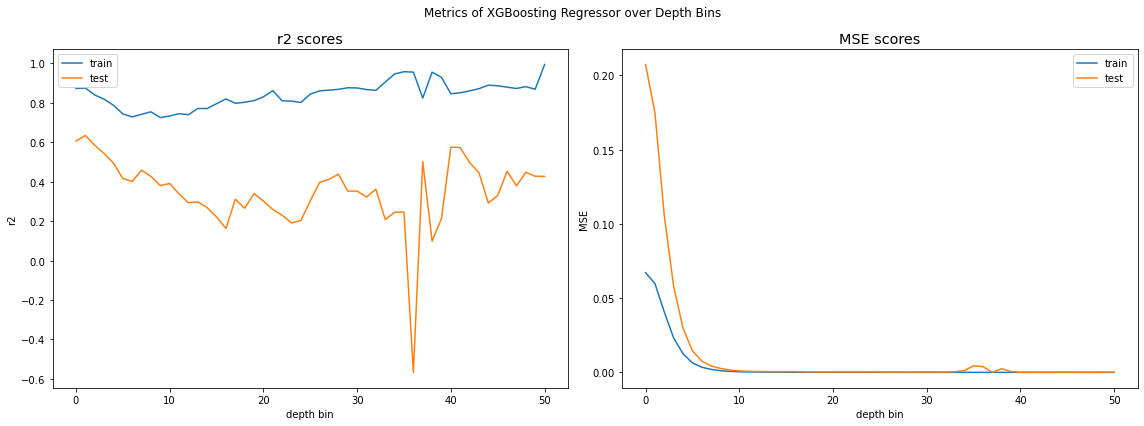

In [20]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
# results_df.to_csv('results_xgb_different_depths_ejd.csv', index=False)
